In [1]:
import pandas as pd
import json
from nltk.stem.porter import PorterStemmer
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

from sklearn.linear_model import LogisticRegression


import matplotlib.pyplot as plt

from scipy.sparse import csc_matrix, csr_matrix

import xgboost as xgb

np.set_printoptions(precision=4)

from sklearn import metrics

import tensorflow as tf
import math 


%matplotlib inline 

In [2]:
import requests
url = "https://raw.githubusercontent.com/abulbasar/machine-learning/master/Utils.py"
exec(requests.get(url).text)

In [3]:
print(nltk.__version__, tf.__version__)

3.2.4 1.3.0


In [4]:
!head -n 1 /data/IMDB-review/imdb-comments.json

{"label":"test","sentiment":"pos","name":"0_10.txt","content":"I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge."}


In [5]:
data = []
with open("/data/IMDB-review/imdb-comments.json", "r", encoding="utf8") as f:
    for l in f.readlines():
        data.append(json.loads(l))    

In [6]:
comments = pd.DataFrame.from_dict(data)
comments.sample(25)

,content,label,name,sentiment
35503,When this film was originally released it was ...,train,8203_7.txt,pos
25536,Yes this movie is predictable and definitely n...,train,10483_8.txt,pos
6937,I think the consensus is pretty unanimous abou...,test,4995_7.txt,pos
25440,The making of The Thief Of Bagdad is quite a s...,train,10397_8.txt,pos
38971,I tuned into this thing one night on a cable c...,train,11324_3.txt,neg
47338,"I guess that ""Gunslinger"" wasn't quite as god-...",train,7605_4.txt,neg
42779,"I understand the jokes quite well, they just a...",train,3501_1.txt,neg
20455,I wasn`t expecting much with HARLEM NIGHTS but...,test,5910_2.txt,neg
8398,I was a little worried about actors and acting...,test,6309_9.txt,pos
11254,"I am surprised people, after such lousy movies...",test,8880_7.txt,pos


In [7]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
content      50000 non-null object
label        50000 non-null object
name         50000 non-null object
sentiment    50000 non-null object
dtypes: object(4)
memory usage: 1.5+ MB


In [8]:
comments.label.value_counts()

train    25000
test     25000
Name: label, dtype: int64

In [9]:
comments.groupby(["label", "sentiment"]).content.count().unstack()

sentiment,neg,pos
label,,
test,12500,12500
train,12500,12500


In [10]:
np.random.seed(1)
v = list(comments["content"].sample(1))[0]
v

'When we started watching this series on cable, I had no idea how addictive it would be. Even when you hate a character, you hold back because they are so beautifully developed, you can almost understand why they react to frustration, fear, greed or temptation the way they do. It\'s almost as if the viewer is experiencing one of Christopher\'s learning curves.<br /><br />I can\'t understand why Adriana would put up with Christopher\'s abuse of her, verbally, physically and emotionally, but I just have to read the newspaper to see how many women can and do tolerate such behavior. Carmella has a dream house, endless supply of expensive things, but I\'m sure she would give it up for a loving and faithful husband - or maybe not. That\'s why I watch.<br /><br />It doesn\'t matter how many times you watch an episode, you can find something you missed the first five times. We even watch episodes out of sequence (watch season 1 on late night with commercials but all the language, A&E with lang

In [11]:
def preprocess(text):
    text = BeautifulSoup(text, "html5lib").text.lower() #removed html tags
    text = re.sub("[\W]+", " ", text)
    return text

preprocess(v)

'when we started watching this series on cable i had no idea how addictive it would be even when you hate a character you hold back because they are so beautifully developed you can almost understand why they react to frustration fear greed or temptation the way they do it s almost as if the viewer is experiencing one of christopher s learning curves i can t understand why adriana would put up with christopher s abuse of her verbally physically and emotionally but i just have to read the newspaper to see how many women can and do tolerate such behavior carmella has a dream house endless supply of expensive things but i m sure she would give it up for a loving and faithful husband or maybe not that s why i watch it doesn t matter how many times you watch an episode you can find something you missed the first five times we even watch episodes out of sequence watch season 1 on late night with commercials but all the language a e with language censored reruns on the movie network whenever 

In [12]:
%%time
comments["content"] = comments["content"].apply(preprocess)

CPU times: user 50.8 s, sys: 0 ns, total: 50.8 s
Wall time: 50.8 s


In [13]:
comments_train = comments[comments["label"] == "train"]
comments_train.sample(10)

,content,label,name,sentiment
25496,there are many people in our lives that we mee...,train,10447_10.txt,pos
41520,sixth escapade for freddy krueger in which he ...,train,2369_4.txt,neg
48525,the first few minutes of the bodyguard do have...,train,8674_2.txt,neg
26037,after reviewing this intense martial arts movi...,train,10934_10.txt,pos
43823,triumph of love is proof that not every coméd...,train,4441_3.txt,neg
39666,this is without a doubt the worst movie i have...,train,11950_2.txt,neg
40882,i had the opportunity to preview this film as ...,train,1795_2.txt,neg
43156,roeg has done some great movies but this a tur...,train,3841_1.txt,neg
37185,possible spoiler in some way how to alienate f...,train,9718_7.txt,pos
40330,sogo ishii can be a skilled filmmaker under th...,train,1298_3.txt,neg


In [14]:
comments_test = comments[comments["label"] == "test"]
comments_test.sample(10)

,content,label,name,sentiment
21277,this is one of those movies where i was rootin...,test,6650_1.txt,neg
12620,spoilersi m going to be as kind as i can about...,test,10108_1.txt,neg
4485,as a former erasmus student i enjoyed this fil...,test,2788_9.txt,pos
4744,francis ford coppola s masterpiece was a great...,test,301_10.txt,pos
10329,some of the reviewers here have foolishly judg...,test,8047_10.txt,pos
14366,this is by far one of the most pretentious fil...,test,11680_1.txt,neg
1007,this is truly a funny movie his dance scene do...,test,10907_8.txt,pos
4539,this film released in 1951 has the usual eleme...,test,2836_8.txt,pos
7864,one of the best tv shows out there if not the ...,test,5829_10.txt,pos
19582,this movie was jerry bruckheimer s idea to sel...,test,5124_4.txt,neg


In [15]:
X_train = comments_train["content"].values
y_train = np.where(comments_train.sentiment == "pos", 1, 0)

In [16]:
X_test = comments_test["content"].values
y_test = np.where(comments_test.sentiment == "pos", 1, 0)

In [17]:
# http://snowball.tartarus.org/algorithms/porter/stemmer.html
porter = PorterStemmer()
for s in "revival allowance inference relational".split():
    print(s, porter.stem(s))

revival reviv
allowance allow
inference infer
relational relat


In [18]:
def my_tokenier(s):
    return [porter.stem(w) for w in nltk.word_tokenize(s)]
my_tokenier("The sun is shining. Allowance")

['the', 'sun', 'is', 'shine', '.', 'allow']

In [19]:
stop = stopwords.words("english")
tfidf = TfidfVectorizer(tokenizer=my_tokenier, ngram_range=(1, 2), stop_words = stop)

docs = ["The sun is shining allowance", "The weather is sweet", "the sun is shining and the weather is sweet"]
print("TFIDF matrix: \n", tfidf.fit_transform(docs).toarray())
print("Vocabulary: ", tfidf.vocabulary_) # returns term and index in the feature matrix

TFIDF matrix: 
 [[ 0.5174  0.3935  0.5174  0.      0.3935  0.3935  0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.5774  0.5774  0.5774]
 [ 0.      0.3597  0.      0.473   0.3597  0.3597  0.3597  0.3597  0.3597]]
Vocabulary:  {'sun': 4, 'shine': 1, 'allow': 0, 'sun shine': 5, 'shine allow': 2, 'weather': 7, 'sweet': 6, 'weather sweet': 8, 'shine weather': 3}


In [20]:
%%time
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

CPU times: user 2min 50s, sys: 184 ms, total: 2min 50s
Wall time: 2min 50s


In [21]:
X_test_tfidf.shape, y_test.shape, X_train_tfidf.shape, y_train.shape

((25000, 1585362), (25000,), (25000, 1585362), (25000,))

In [22]:
cell_count = X_test_tfidf.shape[0] * X_test_tfidf.shape[1]
cell_count * 4 / (1024 ** 3) # GB 

147.64834195375443

In [23]:
sparsity = 1 - X_train_tfidf.count_nonzero() / cell_count
sparsity

0.9998577816296845

In [24]:
1 - X_train_tfidf.nnz / cell_count

0.9998577816296845

Important terms

In [25]:
terms = pd.DataFrame({"term": pd.Series(tfidf.vocabulary_), 
              "avg_score": np.array(csc_matrix.mean(X_train_tfidf, axis=0))[0, :]})
terms= terms.reset_index()
terms = terms.sort_values("avg_score", ascending = False)
del terms["term"]
print("Total important terms", terms.shape[0])
terms.head(10)

Total important terms 1585362


,index,avg_score
1391748,thi,0.028844
919472,movi,0.026900
518561,film,0.023091
1504105,wa,0.023083
655814,hi,0.014616
984380,one,0.013722
1394790,thi movi,0.012572
806031,like,0.012431
600457,good,0.010272
1519015,watch,0.010097


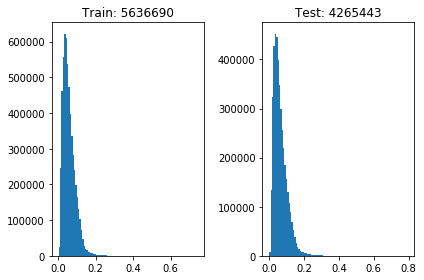

In [26]:
plt.subplot(1, 2, 1)
plt.hist(X_train_tfidf.data, bins = 100);
plt.title("Train: %d" % (len(X_train_tfidf.data)))
plt.subplot(1, 2, 2)
plt.hist(X_test_tfidf.data, bins = 100)
plt.title("Test: %d" % (len(X_test_tfidf.data)))
plt.tight_layout()

In [27]:
%%time
lr = LogisticRegression(C = 1, random_state = 0, n_jobs = 8, solver="saga")
lr.fit(X_train_tfidf, y_train)
y_test_pred = lr.predict(X_test_tfidf)
print("accuracy: ", metrics.accuracy_score(y_test, y_test_pred))

accuracy:  0.8862
CPU times: user 4.72 s, sys: 108 ms, total: 4.83 s
Wall time: 4.88 s


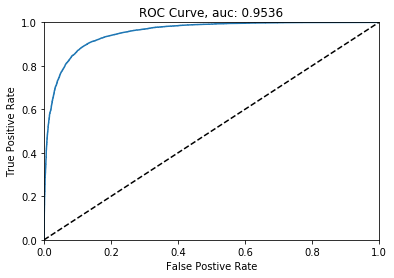

In [28]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, lr.predict_proba(X_test_tfidf)[:, [1]])
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.plot([0,1], [0,1], ls = "--", color = "k")
plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve, auc: %.4f" % auc);

In [29]:
%%time
from sklearn.naive_bayes import MultinomialNB
bayes = MultinomialNB(alpha=1)
bayes.fit(X_train_tfidf, y_train)
print("accuracy: ", bayes.score(X_test_tfidf, y_test))

accuracy:  0.86536
CPU times: user 196 ms, sys: 104 ms, total: 300 ms
Wall time: 198 ms


In [30]:
%%time
gbm = xgb.XGBClassifier(n_jobs = 8, max_depth=10, gamma= 0.1)
gbm.fit(X_train_tfidf, y_train)
print("accuracy: ", gbm.score(X_test_tfidf, y_test))

accuracy:  0.85312
CPU times: user 11min 36s, sys: 1.87 s, total: 11min 38s
Wall time: 2min 12s


{'iteration': 0, 'cost': 0.69315331357091492, 'train accuracy': 0.4765625, 'test accuracy': 0.64164001}
{'iteration': 100, 'cost': 0.60099022971449678, 'train accuracy': 0.98046875, 'test accuracy': 0.85004002}
{'iteration': 200, 'cost': 0.52921237754037875, 'train accuracy': 0.9765625, 'test accuracy': 0.85751998}
{'iteration': 300, 'cost': 0.46615370963605862, 'train accuracy': 0.97265625, 'test accuracy': 0.86148}
{'iteration': 400, 'cost': 0.41335510934947772, 'train accuracy': 0.984375, 'test accuracy': 0.86603999}
{'iteration': 500, 'cost': 0.36252826611504185, 'train accuracy': 0.984375, 'test accuracy': 0.86900002}
{'iteration': 600, 'cost': 0.31633576823769805, 'train accuracy': 0.99609375, 'test accuracy': 0.87224001}
{'iteration': 700, 'cost': 0.2830070532559803, 'train accuracy': 0.9921875, 'test accuracy': 0.87459999}
{'iteration': 800, 'cost': 0.26008255560317595, 'train accuracy': 0.9921875, 'test accuracy': 0.87668002}
{'iteration': 900, 'cost': 0.23339452493526841, 'tr

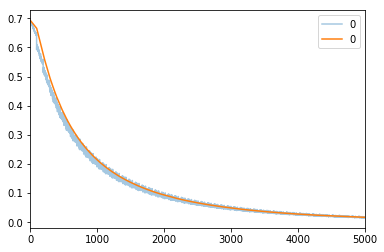

In [31]:
tf.reset_default_graph()

n_x, n_y = 1585362, 2
n_h = 100
iterations = 5000
alpha = 0.0
scores = []

def to_sparse_tensor_value(a):
    indices = np.array(a.nonzero()).T
    return tf.SparseTensorValue(indices, a.data, np.array(a.shape))

#X = tf.placeholder(tf.float32, [None, n_x], "X")
X = tf.sparse_placeholder(tf.float64, [None, n_x], "X")
y = tf.placeholder(tf.int32, [None], "y")

y_oh = tf.one_hot(y, depth = n_y)

W1 = tf.get_variable("W1", initializer = tf.contrib.layers.xavier_initializer(), shape=[n_x, n_y], dtype=tf.float64)
b1 = tf.zeros([n_y], name="b", dtype=tf.float64)
A1 = tf.nn.relu(tf.sparse_tensor_dense_matmul(X, W1) + b1)

W2 = tf.get_variable("W2", initializer = tf.contrib.layers.xavier_initializer(), shape=[n_h, n_y], dtype=tf.float64)
b2 = tf.zeros([n_y], name="b", dtype=tf.float64)

#y_pred = tf.matmul(X, W1) + b1
y_pred = tf.sparse_tensor_dense_matmul(X, W1) + b1

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels= y_oh) + alpha * tf.nn.l2_loss(W1))
optimization = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
correct_mask = tf.equal(tf.argmax(y_pred, 1, output_type=tf.int32), y)
accuracy = tf.reduce_mean(tf.cast(correct_mask, tf.float32))

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    batchable = Batchable(X_train_tfidf, y_train,batch_size=256)
    for i in range(iterations):
        X_batch, y_batch = batchable.next()

        _, cost_, train_accuracy_ = sess.run([optimization, cost, accuracy], 
                                             feed_dict={X: to_sparse_tensor_value(X_batch), y: y_batch})
        scores.append(cost_)
        if i % 100 == 0:
            test_accuracy = sess.run(accuracy, feed_dict = {X: to_sparse_tensor_value(X_test_tfidf), y: y_test})
            d = {"iteration": i,"cost": cost_, "train accuracy": train_accuracy_, "test accuracy": test_accuracy}
            print(d)
show(scores)